<a href="https://colab.research.google.com/github/JPS4321/Lab1_SDS/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Laboratorio 1: Deteccion de Phishing**

- Juan Pablo Solis
- Andres Yatmian Jo Mai

### **Parte 1: Ingeniería de características**

In [55]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from collections import Counter
from math import log2
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
    auc
)



In [56]:

df = pd.read_csv("sample_data/dataset_pishing.csv")

df.head()


,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [57]:
conteo = df['status'].value_counts()

print("Cantidad por clase:")
print(conteo)


Cantidad por clase:
status
legitimate    5715
phishing      5715
Name: count, dtype: int64


El dataset esta balanceado al tener la misma cantidad de observaciones de phishing como legitimas.

### **Derivación de características**

- ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?

El análisis de una URL ofrece varias ventajas frente al análisis de otros datos como el tiempo de vida del dominio o las características del contenido de la página, principalmente porque permite una detección más rápida, segura y en tiempo real sin necesidad de descargar el sitio web, lo que reduce riesgos de exposición a malware y disminuye el consumo de recursos. Además, no depende de servicios externos como consultas WHOIS o DNS, lo que mejora la eficiencia y escalabilidad del sistema. Otra ventaja a mencionar es que las URl utilizadas para phishing tienen un tiempo de vida relativamente corto, por lo que la informacion que se puede obtener de ahi es irrelevante.

- ¿Qué características de una URL son más prometedoras para la detección de phishing?

Las características más prometedoras son: la longitud excesiva de la dirección, el uso de direcciones IP en lugar de nombres de dominio, la presencia y frecuencia de caracteres especiales, el número elevado de subdominios y la estructura anómala del enlace. Es bastante importante la distribución y entropía de caracteres no alfanuméricos, ya que los atacantes suelen insertar símbolos, guiones, múltiples puntos o parámetros innecesarios para simular legitimidad o redirigir al usuario. Estas propiedades léxicas permiten distinguir patrones sospechosos sin necesidad de analizar el contenido completo del sitio, lo que las convierte en indicadores sólidos para modelos de aprendizaje automático enfocados en detección basada exclusivamente en URL.

In [58]:
def url_length(url):
    return len(url)

def count_dots(url):
    return url.count('.')

def count_hyphens(url):
    return url.count('-')

def count_subdomains(url):
    domain = urlparse(url).netloc
    return domain.count('.')

def has_ip(url):
    pattern = r'http[s]?://\d+\.\d+\.\d+\.\d+'
    return int(bool(re.search(pattern, url)))

def count_special_chars(url):
    return len(re.findall(r'[^a-zA-Z0-9]', url))

def ratio_special_chars(url):
    total = len(url)
    special = count_special_chars(url)
    return special / total if total > 0 else 0

def count_digits(url):
    return sum(c.isdigit() for c in url)

def ratio_digits(url):
    total = len(url)
    digits = count_digits(url)
    return digits / total if total > 0 else 0

def shannon_entropy(url):
    prob = [float(url.count(c)) / len(url) for c in dict.fromkeys(url)]
    return -sum([p * log2(p) for p in prob])

def nan_entropy(url):
    nan_chars = re.findall(r'[^a-zA-Z0-9]', url)
    if len(nan_chars) == 0:
        return 0
    freq = Counter(nan_chars)
    prob = [v/len(nan_chars) for v in freq.values()]
    return -sum(p * log2(p) for p in prob)

def relative_entropy(url):
    freq = Counter(url)
    total = len(url)
    prob = [v/total for v in freq.values()]
    uniform_prob = 1/len(freq)
    return sum(p * log2(p/uniform_prob) for p in prob)

def has_https(url):
    return int(url.startswith("https"))

def count_parameters(url):
    return url.count('&')


def domain_length(url):
    return len(urlparse(url).netloc)


In [59]:
df['url_length'] = df['url'].apply(url_length)
df['dots'] = df['url'].apply(count_dots)
df['hyphens'] = df['url'].apply(count_hyphens)
df['subdomains'] = df['url'].apply(count_subdomains)
df['has_ip'] = df['url'].apply(has_ip)
df['special_chars'] = df['url'].apply(count_special_chars)
df['ratio_special'] = df['url'].apply(ratio_special_chars)
df['digits'] = df['url'].apply(count_digits)
df['ratio_digits'] = df['url'].apply(ratio_digits)
df['entropy'] = df['url'].apply(shannon_entropy)
df['nan_entropy'] = df['url'].apply(nan_entropy)
df['relative_entropy'] = df['url'].apply(relative_entropy)
df['https'] = df['url'].apply(has_https)
df['parameters'] = df['url'].apply(count_parameters)
df['domain_length'] = df['url'].apply(domain_length)


In [60]:
df.head()

,url,status,url_length,dots,hyphens,subdomains,has_ip,special_chars,ratio_special,digits,ratio_digits,entropy,nan_entropy,relative_entropy,https,parameters,domain_length
0,http://www.crestonwood.com/router.php,legitimate,37,3,0,2,0,7,0.189189,0,0.000000,3.787043,1.448816,0.212957,0,0,19
1,http://shadetreetechnology.com/V4/validation/a...,phishing,77,1,0,1,0,7,0.090909,17,0.220779,4.419864,1.148835,0.438117,0,0,23
2,https://support-appleld.com.secureupdate.duila...,phishing,126,4,1,4,0,19,0.150794,19,0.150794,4.753412,2.755058,0.290982,1,2,50
3,http://rgipt.ac.in,legitimate,18,2,0,2,0,5,0.277778,0,0.000000,3.461320,1.521928,0.123642,0,0,11
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate,55,2,2,2,0,10,0.181818,0,0.000000,4.097662,1.760964,0.224266,0,0,15


#### **Preprocesamiento**

In [61]:
df['status'] = df['status'].map({'legitimate': 0, 'phishing': 1})
df['status'].value_counts()


,count
status,
0,5715
1,5715


In [62]:
df = df.drop(columns=['url'])


In [63]:
df.dtypes


,0
status,int64
url_length,int64
dots,int64
hyphens,int64
subdomains,int64
has_ip,int64
special_chars,int64
ratio_special,float64
digits,int64
ratio_digits,float64


In [64]:
# Separar características y etiqueta
X = df.drop(columns=['status'])
y = df['status']


#### **Selección de Características**

In [65]:
# Eliminar columnas con varianza cero
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0)
selector.fit(X)

cols_con_varianza = X.columns[selector.get_support()]

X = X[cols_con_varianza]


In [66]:
# Eliminar filas duplicadas
df = df.drop_duplicates()


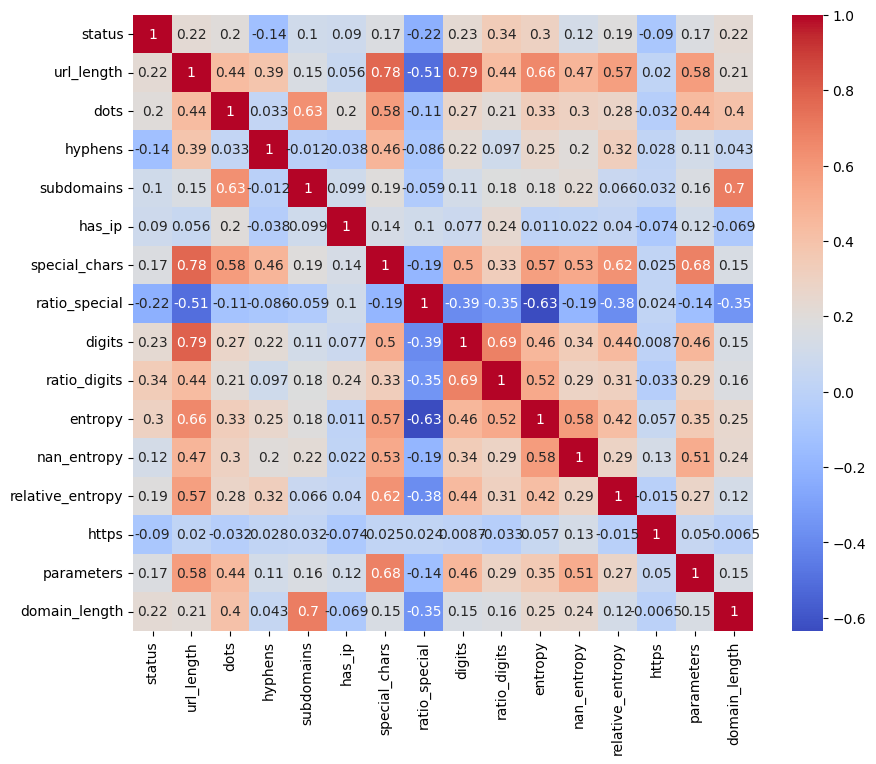

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


In [68]:
corr_status = corr['status'].sort_values(ascending=False)
print(corr_status)


status              1.000000
ratio_digits        0.339910
entropy             0.299570
digits              0.231022
domain_length       0.223139
url_length          0.222389
dots                0.195737
relative_entropy    0.188541
special_chars       0.168131
parameters          0.167134
nan_entropy         0.122669
subdomains          0.102249
has_ip              0.089536
https              -0.090033
hyphens            -0.135604
ratio_special      -0.220669
Name: status, dtype: float64


Tras el análisis exploratorio de datos se identificaron las columnas con mayor capacidad discriminativa mediante el estudio de la matriz de correlación con la variable status. Se eliminaron características con baja correlación absoluta, tales como has_ip, https y hyphens, ya que su relación con la variable objetivo fue inferior a 0.12 en valor absoluto, indicando escasa capacidad predictiva. De esta misma manera, se evaluó la posible multicolinealidad entre variables, observándose alta correlación entre entropy y relative_entropy, así como entre url_length, digits y special_chars.

Las características finalmente seleccionadas fueron: ratio_digits, entropy, digits, url_length, domain_length, dots, special_chars, parameters, nan_entropy y subdomains. Estas variables mostraron mayor correlación absoluta con la variable objetivo y capturan patrones estructurales típicos de URLs de phishing, como mayor longitud, mayor proporción de dígitos, mayor entropía y uso más frecuente de subdominios y parámetros.

In [69]:
cols_to_drop = ['has_ip', 'https', 'hyphens', 'ratio_special', 'relative_entropy']
X = X.drop(columns=cols_to_drop)


In [70]:
print("Dimensiones después de eliminar variables:")
print(df.shape)


Dimensiones después de eliminar variables:
(10554, 16)


## Separación de datos

En esta parte se va a realizar la separación del dataset a datos de entrenamiento a 55%, datos de validación a 15% y datos de prueba 30%

In [71]:
from sklearn.model_selection import train_test_split


# No se puede separar en tres por lo tanto primero se separa el dataset de entrenamiento y luego
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.45,      # 45% = val + test
    random_state=42,
    shuffle=True
)

#Aqui realizamos la separación de prueba y validación
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=2/3,       # 2/3 es 30% y 1/3 es 15% de la separación del data set
    random_state=42,
    shuffle=True
)

Se separan los datasets como pide en el laboratorio.

In [72]:
train_df = pd.concat([X_train, y_train], axis=1)
val_df   = pd.concat([X_val, y_val], axis=1)
test_df  = pd.concat([X_test, y_test], axis=1)

train_df.to_csv("sample_data/train.csv", index=False)
val_df.to_csv("sample_data/validation.csv", index=False)
test_df.to_csv("sample_data/test.csv", index=False)

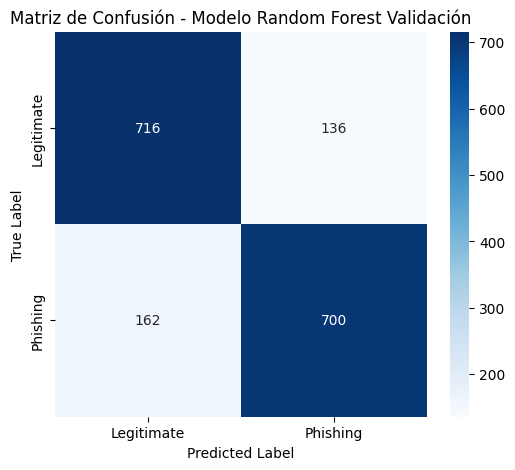

In [73]:



# Train model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = rf_model.predict(X_val)

# Compute confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Legitimate", "Phishing"],
    yticklabels=["Legitimate", "Phishing"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusión - Modelo Random Forest Validación" )
plt.show()


En la matriz de confusión, se muestra que 716 urls son detectadas como legitimias mientras que 700 de ellas no son. Por otro lado se identificaron pocas muestras de falsos negativos y positivos. Se presentan 136 falsos positivos lo cual tiene menor cantidad a  diferencia con los 162 falsos negativos.

El modelo al presentar más falsos negativos se puede inferir que es un riesgo que no se puede aceptar debido a que pueden permite ataques a entidades ya que es emitido como seguro lo cual el phishing trata de hacerlo

In [74]:
# Predicciones
y_val_pred  = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

# Probabilidades (necesarias para ROC y AUC)
y_val_proba  = rf_model.predict_proba(X_val)[:, 1]
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

Confusion Matrix (Test):
 [[1443  272]
 [ 311 1404]]


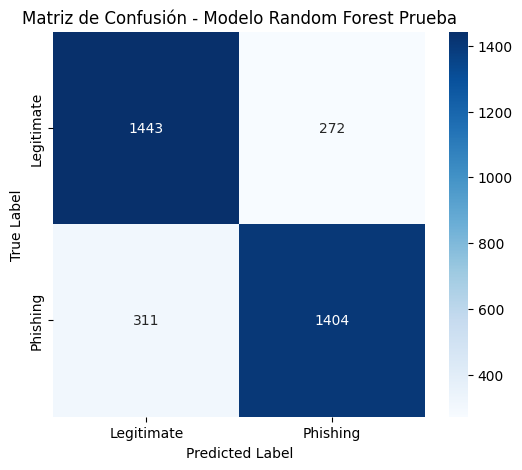

In [75]:
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(y_test, y_test_pred)

print("Confusion Matrix (Test):\n", cm_test)




# Train model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = rf_model.predict(X_val)

# Compute confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Legitimate", "Phishing"],
    yticklabels=["Legitimate", "Phishing"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusión - Modelo Random Forest Prueba")
plt.show()



Aunque el modelo presenta un desempeño sólido en el conjunto de prueba, se observa que los falsos negativos 311 es mayor que el de falsos positivos. Esto significa que representa un riesgo significativo, ya que el objetivo principal del atacante es hacerse pasar por un sitio legítimo.

Por esta razón, se debe de priorizar la reducción de falsos negativos, incluso si esto implica un incremento moderado de falsos positivos.

In [76]:
from sklearn.metrics import precision_score, recall_score

print("Validation Precision:", precision_score(y_val, y_val_pred))
print("Validation Recall:", recall_score(y_val, y_val_pred))

print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))


Validation Precision: 0.8373205741626795
Validation Recall: 0.8120649651972158
Test Precision: 0.837708830548926
Test Recall: 0.8186588921282799


La precision cercana al 84% sugiere que la mayoría de las URLs clasificadas como phishing son efectivamente maliciosas, mientras que el recall superior al 80% refleja una buena capacidad de detección de ataques reales.

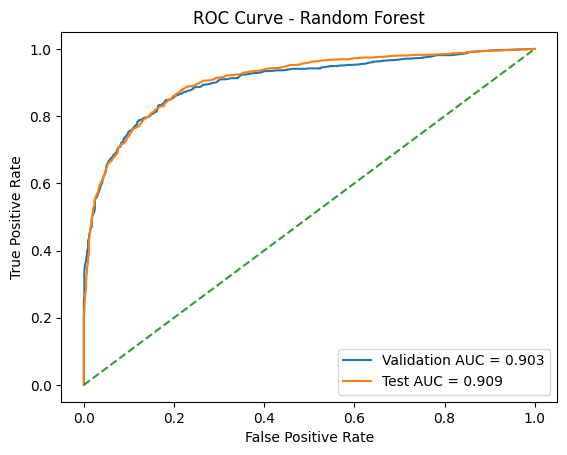

In [77]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Validation ROC
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
auc_val = auc(fpr_val, tpr_val)

# Test ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
auc_test = auc(fpr_test, tpr_test)

# Plot
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation AUC = {auc_val:.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


La curva ROC del modelo Random Forest muestra un desempeño sobresaliente, con valores de AUC superiores a 0.90 tanto en el conjunto de validación como en el de prueba. Esto indica una alta capacidad de discriminación entre URLs legítimas y de phishing.

A continuación, se implementa un modelo de regresión logística, dado que la variable objetivo status se encuentra definida de forma binaria (0 y 1), lo que lo convierte en un enfoque adecuado para problemas de clasificación binaria.

In [78]:
# Load datasets
train_df = pd.read_csv("sample_data/train.csv")
val_df   = pd.read_csv("sample_data/validation.csv")
test_df  = pd.read_csv("sample_data/test.csv")



# Split X and y
X_train = train_df.drop(columns=["status"])
y_train = train_df["status"]

X_val = val_df.drop(columns=["status"])
y_val = val_df["status"]

X_test = test_df.drop(columns=["status"])
y_test = test_df["status"]


In [79]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [80]:
log_reg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [81]:
# Class predictions
y_val_pred  = log_reg.predict(X_val_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Probabilities (for ROC & AUC)
y_val_proba  = log_reg.predict_proba(X_val_scaled)[:, 1]
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]


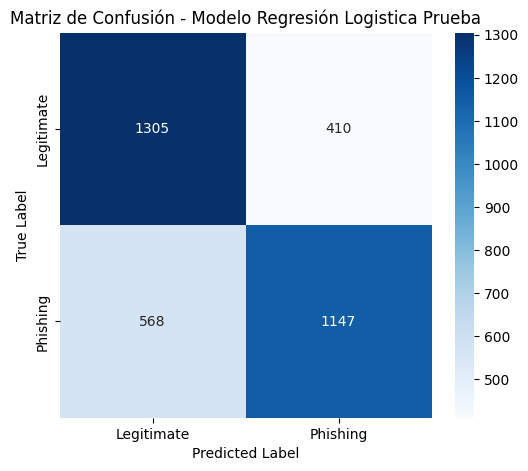

In [82]:
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Legitimate", "Phishing"],
    yticklabels=["Legitimate", "Phishing"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusión - Modelo Regresión Logistica Prueba")
plt.show()


La matriz de confusión del modelo de regresión logística muestra un desempeño inferior en comparación con Random Forest, especialmente en la detección de URLs de phishing. El elevado número de falsos negativos representa un riesgo significativo.

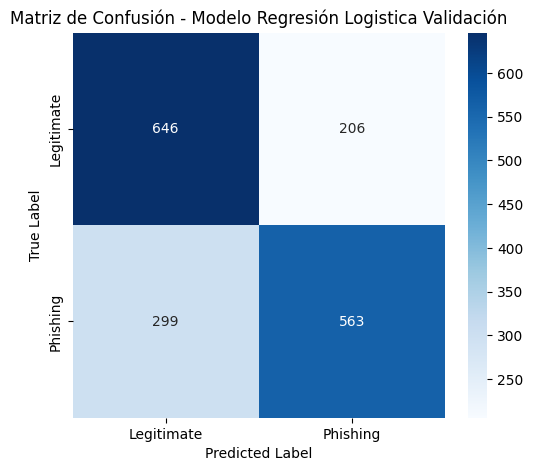

In [83]:
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Legitimate", "Phishing"],
    yticklabels=["Legitimate", "Phishing"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusión - Modelo Regresión Logistica Validación")
plt.show()


In [84]:
print("Validation Precision:", precision_score(y_val, y_val_pred))
print("Validation Recall:", recall_score(y_val, y_val_pred))

print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))


Validation Precision: 0.7321196358907672
Validation Recall: 0.6531322505800464
Test Precision: 0.7366730892742454
Test Recall: 0.668804664723032


Los resultados de precision y recall para la regresión logística muestran un desempeño limitado tanto en el conjunto de validación como en el de prueba. Aunque el modelo presenta estabilidad, su bajo recall indica una insuficiente capacidad para detectar URLs de phishing, lo que resulta crítico en aplicaciones de seguridad. En comparación con Random Forest, la regresión logística muestra un rendimiento inferior, lo que evidencia las limitaciones de los modelos lineales frente a patrones no lineales presentes en los ataques de phishing.

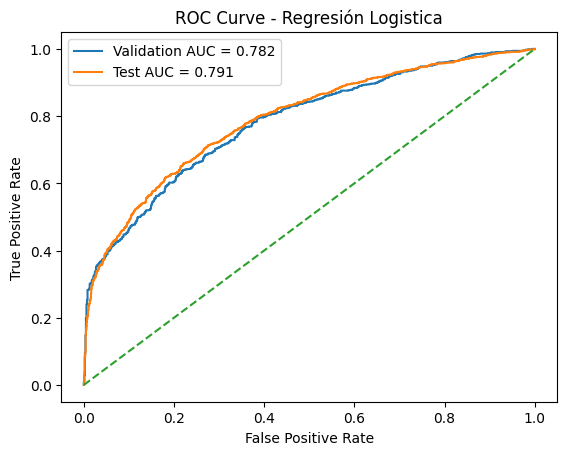

In [85]:
# Validation ROC
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
auc_val = auc(fpr_val, tpr_val)

# Test ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation AUC = {auc_val:.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Regresión Logistica")
plt.legend()
plt.show()


La curva ROC de la regresión logística presenta valores de AUC cercanos a 0.78 en validación y 0.79 en prueba, lo que indica una capacidad moderada de discriminación entre URLs legítimas y de phishing. Si bien el modelo muestra estabilidad y generalización, su desempeño es inferior al obtenido con Random Forest, evidenciando las limitaciones de los modelos lineales para capturar patrones complejos en ataques de phishing.

## ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?

Clasificar un sitio legítimo como phishing representa como un falso positivo es mejor que un falso negativo, lo que puede afectar el accesos a páginas seguras y generar desconfianza en el sistema de seguridad. Aunque el impacto para el usuario, es preferible ante ser una victima del phishing, ya que estos  pueden comprometer la seguridad de los usuarios y las organizaciones.

## ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?

Esto es representado como un falso negativo y constituye el error más crítico en sistemas de detección de phishing. Este tipo de error permite que ataques reales pasen desapercibidos, exponiendo a los usuarios a fraudes, robo de información y pérdidas económicas. Por esta razón, en aplicaciones de seguridad se prioriza la reducción de falsos negativos, aun cuando ello implique incrementar el número de falsos positivos.

## En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?

En métricas, es preferible utilizar recall ya que penaliza directamente los falsos negativos, los cuales representan el error más crítico al permitir que ataques reales pasen desapercibidos.

## ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?

El mejor modelo para realizar la clasificación de phishing fue el modelo de Random Forest a comparación de la regresión logistica. Esto se evidencia en un mayor recall y un AUC superior, lo que indica una mejor capacidad para detectar ataques reales y discriminar entre URLs legítimas y maliciosas. Dado que en detección de phishing es prioritario minimizar los falsos negativos, Random Forest resulta más adecuado para este problema.

El modelo propuesto es funcional para el BR planteado, ya que permite detectar la mayoría de los ataques de phishing. Aunque, hay que tomar en cuenta que el número de falsas alarmas sugiere la necesidad de ajustes adicionales. Para reducir es ideal  modificar el umbral de decisión, implementar un sistema de detección en múltiples etapas y complementar el modelo con reglas heurísticas, logrando así un mejor equilibrio entre seguridad y operación.

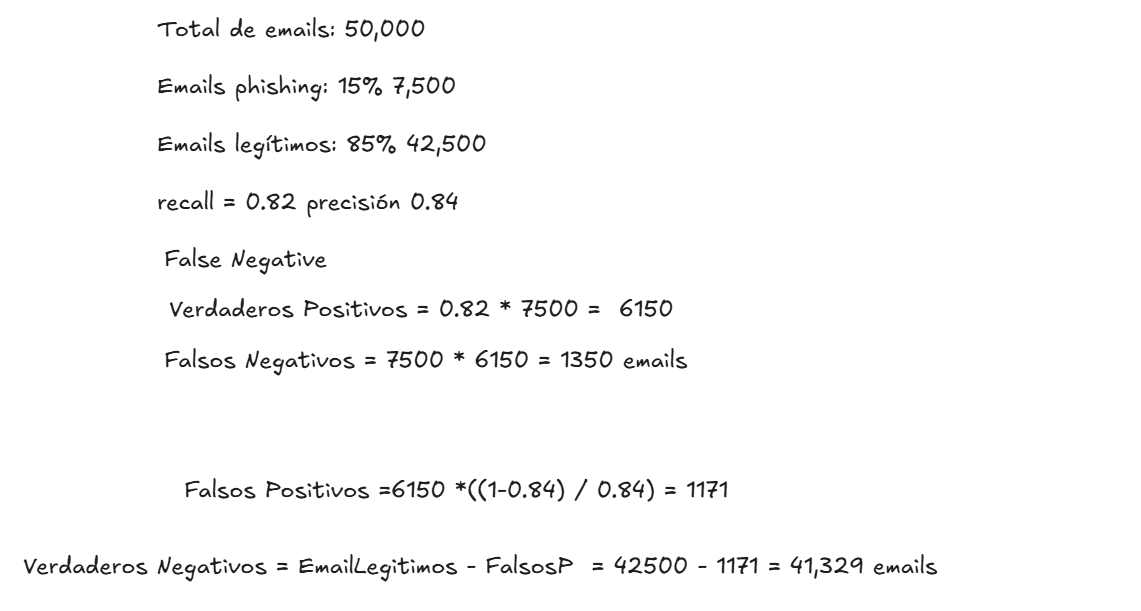